<a href="https://colab.research.google.com/github/Gifourm/speech_recognition_nn/blob/empty_branch/speech_recognition_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TypeError: ignored

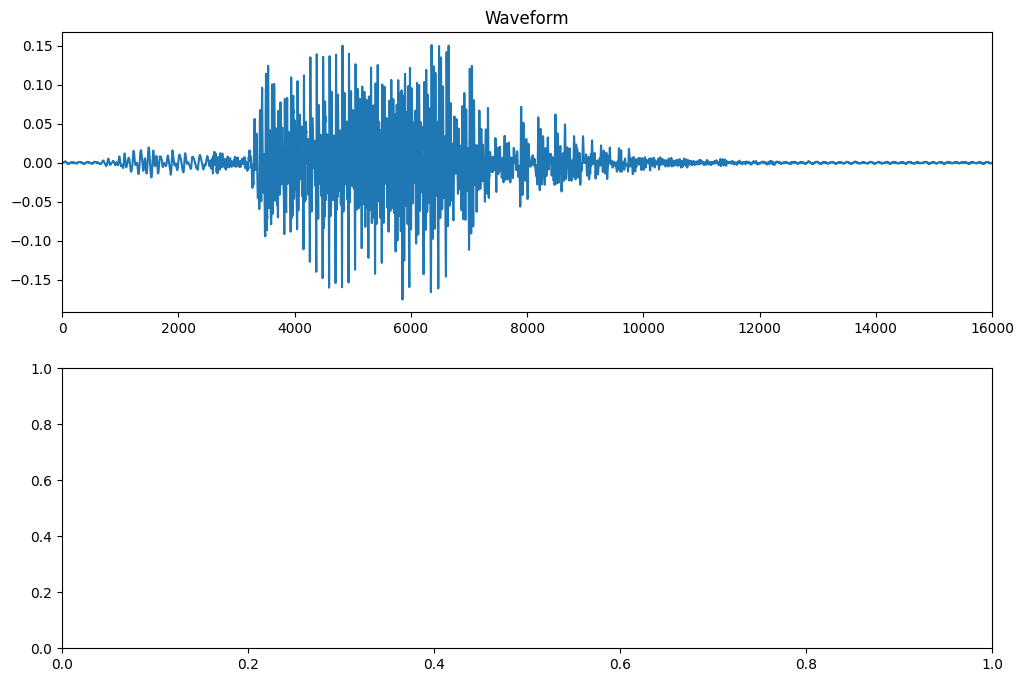

In [10]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


def decode_wav_file(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return tf.squeeze(audio, axis=-1)


def get_labels(file_path):
  label = tf.strings.split(
      input=file_path,
      sep=os.path.sep
  )
  return label[-2]


def get_ds(file_path):
  label = get_labels(file_path)
  audio_binary = tf.io.read_file(file_path)
  decode_wav = decode_wav_file(audio_binary)
  return decode_wav, label


def spectrogram(wave):
  input_len = 16000
  wave = wave[:input_len]
  padding = tf.zeros([input_len] - tf.shape(wave), dtype=tf.float32)

  wave = tf.cast(wave, dtype=tf.float32)
  len = tf.concat([wave, padding], 0)

  specter = tf.signal.stft(len, frame_length=255, frame_step=128)
  specter = specter[..., tf.newaxis]
  return specter


def display_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = numpy.squeeze(spectrogram, axis=-1)
  log_specter = numpy.log(spectrogram.T + numpy.finfo(float).eps)
  height = log_specter.shape[0]
  width = log_specter.shape[1]
  x = numpy.linspace(0, numpy.size(spectrogram), num=width, dtype=int)
  y = range(height)
  ax.pcolormesh(x, y, log_specter)


path = 'data/mini_speech_commands'
tf.keras.utils.get_file(
    'mini_speech_commands.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip',
    extract=True,
    cache_dir='.',
    cache_subdir='data'
)

words = numpy.array(tf.io.gfile.listdir(str(pathlib.Path(path))))
words = words[words != 'README.md']

files = tf.io.gfile.glob(str(path) + '/*/*')
files = tf.random.shuffle(files)

train_ds = files[:int(len(files) / 10 * 6)]
val_ds = files[int(len(files) / 10 * 6):int(len(files) / 10 * 8)]
test_ds = files[-int(len(files) / 10 * 2)]

ds = tf.data.Dataset.from_tensor_slices(train_ds)
waves_ds = ds.map(
    map_func=get_ds,
    num_parallel_calls=tf.data.AUTOTUNE
)

for wave, label in waves_ds.take(1):
  label = label.numpy().decode('utf-8')
  specter = spectrogram(wave)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = numpy.arange(wave.shape[0])
axes[0].plot(timescale, wave.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

display_spectrogram(specter.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

